In [1]:
import os
import cv2
import glob
import random
import numpy as np
import imgaug as ia
import pandas as pd
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
from skimage import transform, filters, exposure
os.environ['CUDA_VISIBLE_DEVICES']='3'
%matplotlib inline
#http://florianmuellerklein.github.io/cnn_streetview/

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def label2int(ch):
    ascii_val = ord(ch)
    if(ascii_val <= 57): #0-9
        ascii_val -= 48
    elif(ascii_val <= 90): #A-Z
        ascii_val -= 55
    else: #a-z
        ascii_val -= 61
    return ascii_val
def int2label(i):
    if(i <= 9): #0-9
        i += 48
    elif(i<=35): #A-Z
        i += 55
    else: #a-z
        i += 61
    return chr(i)

In [3]:
#图片数据持久化，保存到本地，供下次直接调用
def data_preprocessing_bgr(data_path, img_rows=32, img_cols=32):
    if (os.path.exists(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '_1.npy') 
        and os.path.exists(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '_1.npy') 
        and os.path.exists(data_path + '/' + 'labels_3.npy')):
        print('data have already processed')
    else:
        ### Image preprocessing ###
        for set_type in ['train', 'test']:
            files = natsorted(glob.glob(data_path + '/' + set_type + '/*'))
            data = np.zeros((len(files), img_rows, img_cols))
            for i, file_path in enumerate(files):
                #利用opencv读取图片
                img = cv2.imread(file_path, 0)
                img_resized = cv2.resize(img, (img_rows, img_cols))#读入的[0, 255]的图
                data[i] = img_resized               
            #Add channel/filter dimension [222, 32, 32] => [222, 1, 32, 32]
            #train_img = np.stack(train_img)[..., None]
            data = data[:, :, :, np.newaxis]
            data = data.astype('float32')
            #data /= 255
            np.save(data_path + '/' + set_type + '_' + str(img_rows) +  '_' + str(img_cols) + '_1.npy', data)
        ### Labels preprocessing ###
        y_train = pd.read_csv(data_path + '/trainLabels.csv').values[:, 1]
        #Convert one-hot vectors
        Y_train = np.zeros((y_train.shape[0], len(np.unique(y_train))))
        for i in range(y_train.shape[0]):
            Y_train[i][label2int(y_train[i])] = 1
        np.save(data_path + '/' + 'labels_3.npy', Y_train)
    X_train_all = np.load(data_path + '/' + 'train_' + str(img_rows) +  '_' + str(img_cols) + '_1.npy')
    Y_train_all = np.load(data_path + '/' + 'labels_3.npy')
    test_all = np.load(data_path + '/' + 'test_' + str(img_rows) +  '_' + str(img_cols) + '_1.npy')
    print('Finish')
    return X_train_all, Y_train_all, test_all

In [4]:
data_path = 'data'
X_train_all, Y_train_all, test_all = data_preprocessing_bgr(data_path, 64, 64)

data have already processed
Finish


(6283, 64, 64, 1) (6283, 62) (6220, 64, 64, 1)
(64, 64, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
float32


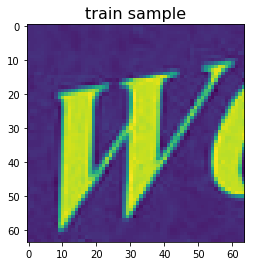

In [36]:
print(X_train_all.shape, Y_train_all.shape, test_all.shape)
sample_x = X_train_all[5]
print(X_train_all[5].shape)
print(Y_train_all[5])
plt.title('train sample', size=16)
plt.imshow(sample_x[..., 0])
print(X_train_all.dtype)

In [37]:
### 划分验证集 ###
#数据预处理 方法二
VALIDATION_SIZE = 200    #验证集大小
x_val, y_val = X_train_all[:VALIDATION_SIZE], Y_train_all[:VALIDATION_SIZE]
x_train, y_train = X_train_all[VALIDATION_SIZE:].astype('uint8'), Y_train_all[VALIDATION_SIZE:].astype('uint8')
print(x_train.shape, x_val.shape)
print(y_val[0].shape)
print(x_train[5][..., 0])

(6083, 64, 64, 1) (200, 64, 64, 1)
(62,)
[[40 44 47 ... 42 44 44]
 [44 46 47 ... 44 42 38]
 [39 45 48 ... 49 45 43]
 ...
 [48 47 46 ... 46 47 51]
 [50 50 50 ... 48 48 47]
 [48 48 48 ... 47 49 47]]


In [26]:
def batch_augment2(data):
    seq = iaa.Sequential([
        iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.5), #上下翻转
        #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-10, 10)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        #iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
        iaa.Sharpen(alpha=0.5),
        #iaa.Scale((0.5, 1.5))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    x_batch = seq.augment_images(data)
    return x_batch

In [22]:
def vgg_like_model(x, classes, is_training):
    with tf.variable_scope('layer1-conv'):
        conv1 = tf.layers.conv2d(x, 128, 3, strides=1, padding='VALID')
        norm1 = tf.layers.batch_normalization(conv1, center=True, scale=True, training=is_training)
        relu1 = tf.nn.relu(norm1)
    with tf.variable_scope('layer2-conv'):
        conv2 = tf.layers.conv2d(relu1, 128, 3, strides=1, padding='VALID')
        norm2 = tf.layers.batch_normalization(conv2, center=True, scale=True, training=is_training)
        relu2 = tf.nn.relu(norm2)
    with tf.variable_scope('layer3-pool'):
        pool3 = tf.layers.max_pooling2d(relu2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer4-conv'):
        conv4 = tf.layers.conv2d(pool3, 256, 3, strides=1, padding='VALID')
        norm4 = tf.layers.batch_normalization(conv4, center=True, scale=True, training=is_training)
        relu4 = tf.nn.relu(norm4)
    with tf.variable_scope('layer5-conv'):
        conv5 = tf.layers.conv2d(relu4, 256, 3, strides=1, padding='VALID')
        norm5 = tf.layers.batch_normalization(conv5, center=True, scale=True, training=is_training)
        relu5 = tf.nn.relu(norm5)  
    with tf.variable_scope('layer6-pool'):
        pool6 = tf.layers.max_pooling2d(relu5, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer7-conv'):
        conv7 = tf.layers.conv2d(pool6, 512, 3, strides=1, padding='VALID')
        norm7 = tf.layers.batch_normalization(conv7, center=True, scale=True, training=is_training)
        relu7 = tf.nn.relu(norm7)  
    with tf.variable_scope('layer8-conv'):
        conv8 = tf.layers.conv2d(relu7, 512, 3, strides=1, padding='VALID')
        norm8 = tf.layers.batch_normalization(conv8, center=True, scale=True, training=is_training)
        relu8 = tf.nn.relu(norm8)
    with tf.variable_scope('layer9-conv'):
        conv9 = tf.layers.conv2d(relu8, 512, 3, strides=1, padding='VALID')
        norm9 = tf.layers.batch_normalization(conv9, center=True, scale=True, training=is_training)
        relu9 = tf.nn.relu(norm9) 
    with tf.variable_scope('layer10-pool'):
        pool10 = tf.layers.max_pooling2d(relu9, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer11-FC'):
        flatten = tf.reshape(pool10, [-1, 4*4*512])
        fc11 = tf.layers.dense(flatten, 2048)
        norm11 = tf.layers.batch_normalization(fc11, center=True, scale=True, training=is_training)
        relu11 = tf.nn.relu(norm11)
        if is_training == True:
            relu11 = tf.layers.dropout(relu11, 0.5)       
    with tf.variable_scope('layer12-FC'):
        fc12 = tf.layers.dense(relu11, 2048)
        norm12 = tf.layers.batch_normalization(fc12, center=True, scale=True, training=is_training)
        relu12 = tf.nn.relu(norm12)
        if is_training == True:
            relu12 = tf.layers.dropout(relu12, 0.5)  
    with tf.variable_scope('layer13-FC'):
        output = tf.layers.dense(relu12, classes) 
    return output

In [40]:
### 训练 ###
#训练参数
BATCH_SIZE = 128
EPOCHS = 500             #迭代次数
EARLY_STOP_PATIENCE = 100 #控制early stopping的参数

tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 64, 64, 1])
y_data = tf.placeholder(tf.float32, [None, 62])
is_training = tf.placeholder(tf.bool)
ckpt_path = './model/mode.ckpt'

predict = vgg_like_model(x_data, 62, is_training)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=y_data))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):#批归一化层
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predict, 1), tf.argmax(y_data, 1)), tf.float32))
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    best_validation_loss = 1000000.0
    current_epoch = 0
    
    epoch = EPOCHS
    batch_size = BATCH_SIZE
    train_size = len(x_train)
    train_index = list(range(train_size))
    for n in range(epoch):
        random.shuffle(train_index)  # 每个epoch都shuffle一下效果更好
        x_train_, y_train_ = x_train[train_index], y_train[train_index]
        #添加交叉验证
        #x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.1, random_state=42, shuffle=True)
        for i in range(0, train_size, batch_size):
            x_batch = x_train_[i : i + batch_size]
            y_batch = y_train_[i : i + batch_size]
            _, loss_step = sess.run([train_step, loss], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
            #数据扩充
            #x_batch_aug = batch_augment2(x_batch)
            #_, loss_aug = sess.run([train_step, loss], \
            #                        feed_dict={x_data:x_batch_aug, y_data:y_batch, is_training:True})
        if n % 5 == 0:
            validation_loss, accuracy = sess.run([loss, acc], feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            #validation_loss = loss.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            #accuracy = acc.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
            print("epoch %d train loss is %f validataion loss is %f accuracy is %f" % (n, loss_step, validation_loss, accuracy))
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            current_epoch = n
            saver.save(sess, ckpt_path)
        elif (n - current_epoch) >= EARLY_STOP_PATIENCE:
            print('early stoping')
            break  

epoch 0 train loss is 2.204450 validataion loss is 37.085663 accuracy is 0.045000
epoch 5 train loss is 0.451701 validataion loss is 1.917642 accuracy is 0.575000
epoch 10 train loss is 0.195826 validataion loss is 1.701146 accuracy is 0.675000
epoch 15 train loss is 0.172256 validataion loss is 1.765121 accuracy is 0.705000
epoch 20 train loss is 0.007429 validataion loss is 1.666669 accuracy is 0.710000
epoch 25 train loss is 0.001719 validataion loss is 1.618080 accuracy is 0.735000
epoch 30 train loss is 0.000298 validataion loss is 1.642537 accuracy is 0.745000
epoch 35 train loss is 0.000374 validataion loss is 1.654060 accuracy is 0.745000
epoch 40 train loss is 0.000406 validataion loss is 1.675276 accuracy is 0.745000
epoch 45 train loss is 0.000237 validataion loss is 1.683625 accuracy is 0.750000
epoch 50 train loss is 0.000343 validataion loss is 1.702956 accuracy is 0.750000
epoch 55 train loss is 0.000116 validataion loss is 1.711277 accuracy is 0.750000
epoch 60 train lo